In [1]:
import numpy as np
from scipy.linalg import cho_solve, cho_factor
import matplotlib.pyplot as plt
import matplotlib
from scipy.interpolate import interp1d
cmap = 'bwr'

from PIL import Image

## load data

In [2]:
import os
import re

data_dir = './data/'
folders = [f for f in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, f)) and f.startswith('G5_res_')]

bin_sizes = set()
collimations = set()
collection_times = set()

for folder in folders:
    parts = folder.split('_')
    if len(parts) >= 4:
        x = parts[2]  # bin size
        y = parts[3].removesuffix('C')  # collimation
        bin_sizes.add(x)
        collimations.add(y)

        folder_path = os.path.join(data_dir, folder)
        for fname in os.listdir(folder_path):
            match = re.match(r'^\d+_d(\d+)_c(\d+)\.dat$', fname)
            if match:
                z1, z2 = match.group(1), match.group(2)
                if z1 == z2:
                    # Strip leading zeros
                    collection_times.add(z1.lstrip('0') or '0')
                else:
                    print(f"Inconsistent collection time in file: {fname}")

print("Possible bin sizes (x):", sorted(bin_sizes))
print("Possible collimations (y):", sorted(collimations))
print("Possible collection times (z):", sorted(collection_times))


Possible bin sizes (x): ['1', '16', '2', '32', '4', '8']
Possible collimations (y): ['17', '8']
Possible collection times (z): ['1', '2', '3', '4', '5', '6', '7']


In [3]:
from collections import defaultdict

class ScatteringData:
    def __init__(self, Q, I, I_err, dQ):
        self.Q = Q
        self.I = I
        self.I_err = I_err
        self.dQ = dQ

data_dir = './data/'
data = defaultdict(lambda: defaultdict(dict))  # data[bin][collimation][time]

folders = [f for f in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, f)) and f.startswith('G5_res_')]

for folder in folders:
    parts = folder.split('_')
    if len(parts) >= 4:
        x = parts[2]  # bin size
        y = parts[3].removesuffix('C')  # collimation
        folder_path = os.path.join(data_dir, folder)

        for fname in os.listdir(folder_path):
            match = re.match(r'^\d+_d(\d+)_c(\d+)\.dat$', fname)
            if match:
                z1, z2 = match.group(1), match.group(2)
                if z1 != z2:
                    print(f"Mismatch in collection time in file: {fname}")
                    continue
                z = z1.lstrip('0') or '0'
                # z = z1

                # Read file, skip until '***** Data *****' is found
                fpath = os.path.join(folder_path, fname)
                with open(fpath, 'r') as f:
                    lines = f.readlines()

                # Find index of the data block
                for i, line in enumerate(lines):
                    if line.strip().startswith('Mod_Q'):
                        data_lines = lines[i+1:]
                        break
                else:
                    print(f"No data block found in {fname}")
                    continue

                # Load numerical data
                try:
                    array = np.loadtxt(data_lines)
                    if array.ndim == 1:
                        array = array[np.newaxis, :]  # handle single-row case
                    Q, I, I_err, dQ = array.T
                    data[x][y][z] = ScatteringData(Q, I, I_err, dQ)
                except Exception as e:
                    print(f"Error loading {fname}: {e}")


39
597
77
1192
151
300


Text(0, 0.5, 'Intensity ($\\mathrm{cm}^{-1}$)')

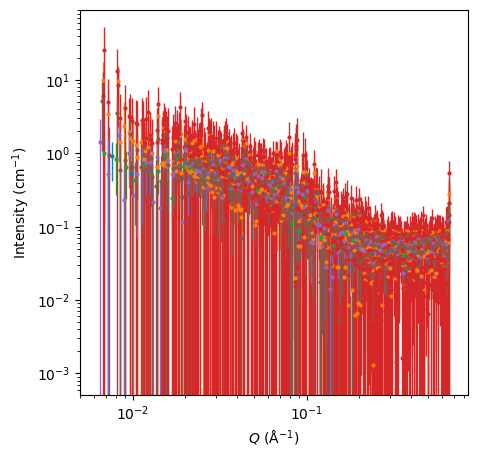

In [4]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)

collimation = '17'
for i_bin, bin_size in enumerate(sorted(data.keys())):
    for i_time, time in enumerate(sorted(data[bin_size][collimation].keys())[0:1]):
        scattering_data = data[bin_size][collimation][time]
        Q = scattering_data.Q
        I = scattering_data.I
        I_err = scattering_data.I_err
        dQ = scattering_data.dQ
        
        ax.errorbar(Q, I, yerr=I_err, label=f'Bin: {bin_size}, Time: {time}', fmt='o', markersize=2, elinewidth=1)
    print(len(Q))
        
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel(r'$Q$ ($\mathrm{\AA}^{-1}$)')
ax.set_ylabel(r'Intensity ($\mathrm{cm}^{-1}$)')


In [5]:
data.keys()

dict_keys(['8', '1', '32', '4', '16', '2'])

In [ ]:
from scipy.signal import savgol_filter
def calculate_avg_counting_error(scattering_data):
    """Calculates the average squared counting error from the I_err array."""
    return np.mean(scattering_data.I_err**2)

def calculate_binning_integral(best_scattering_data):
    """
    Calculates the integral of the squared second derivative.
    This value is a constant for the entire dataset.
    """
    Q_best = best_scattering_data.Q
    I_best = best_scattering_data.I
    
    # 1. Use a Savitzky-Golay filter to get the second derivative of the intensity.
    # The 'deriv=2' argument tells the filter to compute the 2nd derivative.
    # The window length and polyorder are tunable parameters for smoothing.
    smoothed_I_double_prime = savgol_filter(I_best, window_length=4, polyorder=3, deriv=2)
    
    # 2. Square the second derivative.
    I_double_prime_squared = smoothed_I_double_prime**2
    
    # 3. Integrate the squared second derivative over the Q range.
    # We use the trapezoidal rule (np.trapz) for numerical integration.
    integral_val = np.trapz(I_double_prime_squared, Q_best)
    
    return integral_val

def calculate_avg_binning_error(dQ, integral_val, L):
    """
    Calculates the average squared binning distortion for a given bin size.
    """
    if L == 0:
        return np.inf  # Avoid division by zero
    return (dQ**4 / (576 * L)) * integral_val

Using best dataset: Bin size = 1, Time = 7
Integral of (I'')^2: 1.3131e-05


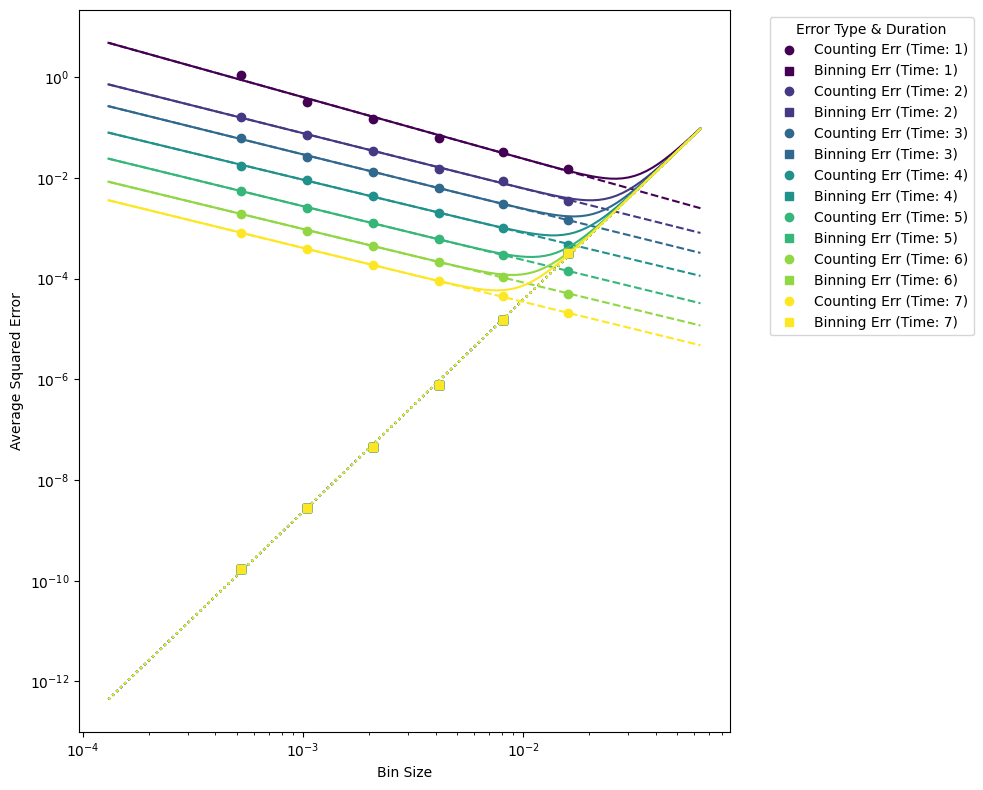

In [29]:
# -------------------------------------------------------------------------
# Step 3: Main Calculation and Visualization
# -------------------------------------------------------------------------

# Select a collimation to analyze
fixed_collimation = '17'

# Find the "best" dataset (longest time, smallest bin size)
sorted_bin_sizes = sorted([int(bs) for bs in data.keys()])
sorted_times = sorted([int(t) for t in data[str(sorted_bin_sizes[0])][fixed_collimation].keys()])

best_bin_size_str = str(sorted_bin_sizes[0])
best_time_str = str(sorted_times[-1])
best_data = data[best_bin_size_str][fixed_collimation][best_time_str]
L = best_data.Q.max() - best_data.Q.min()

print(f"Using best dataset: Bin size = {best_bin_size_str}, Time = {best_time_str}")

# Calculate the integral of the squared second derivative once
integral_of_I_double_prime_sq = calculate_binning_integral(best_data)
print(f"Integral of (I'')^2: {integral_of_I_double_prime_sq:.4e}")

# Store errors for plotting
plot_data = defaultdict(lambda: defaultdict(dict))

# Loop through all datasets for the fixed collimation
for bin_size_str in data.keys():
    for time_str in data[bin_size_str][fixed_collimation].keys():
        current_data = data[bin_size_str][fixed_collimation][time_str]
        
        # Calculate counting error
        counting_err = calculate_avg_counting_error(current_data)
        
        # Calculate binning distortion
        bin_size_val = float(bin_size_str)
        current_Q = current_data.Q
        current_binning_widths = L/len(current_Q)
        current_averaged_resolution = np.mean(current_data.dQ)
        
        binning_err = calculate_avg_binning_error(current_averaged_resolution/bin_size_val, integral_of_I_double_prime_sq, L)
        
        plot_data[str(bin_size_str)][str(time_str)] = {
            'counting': counting_err,
            'binning': binning_err
        }

# Plot the results
fig, ax = plt.subplots(figsize=(10, 8))

colors = plt.cm.viridis(np.linspace(0, 1, len(sorted_times)))
line_styles = ['-o', '-s', '-^', '-D', '-x']

# Loop through each unique collection time
for i, time_val in enumerate(sorted_times):
    time_str = str(time_val)
    
    # Get all bin sizes and errors for the current time
    bin_sizes_for_time = sorted([int(bs) for bs in data.keys()])
    
    counting_errors = [plot_data[str(bs)][time_str]['counting'] for bs in bin_sizes_for_time]
    binning_errors =  [plot_data[str(bs)][time_str]['binning'] for bs in bin_sizes_for_time]
    total_errors = np.array(counting_errors) + np.array(binning_errors)
    
    current_data_binning_widths = L/np.array([len(data[str(bs)][fixed_collimation][time_str].Q) for bs in bin_sizes_for_time])
    
    # Plotting each error type on the same subplot for clarity
    ax.plot(current_data_binning_widths, counting_errors, linestyle='', color=colors[i], marker='o', label=f'Counting Err (Time: {time_str})')
    ax.plot(current_data_binning_widths, binning_errors, linestyle='', color=colors[i], marker='s', label=f'Binning Err (Time: {time_str})')
    ax.plot(current_data_binning_widths, total_errors, linestyle='', color=colors[i], marker="")
    
    # Linear fit the log-log counting_errors and binning_errors
    log_binning_widths = np.log(current_data_binning_widths)
    current_data_binning_widths_fine = np.logspace(np.log10(current_data_binning_widths.min()/4), np.log10(current_data_binning_widths.max()*4), 100)
    log_binning_widths_fine = np.log(current_data_binning_widths_fine)
    log_counting_errors = np.log(counting_errors)
    log_binning_errors = np.log(binning_errors)
    coeffs_counting = np.polyfit(log_binning_widths, log_counting_errors, 1)
    coeffs_binning = np.polyfit(log_binning_widths, log_binning_errors, 1)
    fit_counting = np.exp(np.polyval(coeffs_counting, log_binning_widths_fine))
    fit_binning = np.exp(np.polyval(coeffs_binning, log_binning_widths_fine))
    
    ax.plot(current_data_binning_widths_fine, fit_counting, linestyle='dashed', color=colors[i])
    ax.plot(current_data_binning_widths_fine, fit_binning, linestyle='dotted', color=colors[i])
    ax.plot(current_data_binning_widths_fine, fit_counting + fit_binning, linestyle='solid', color=colors[i])

ax.set_xlabel('Bin Size')
ax.set_ylabel('Average Squared Error')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(title='Error Type & Duration', bbox_to_anchor=(1.05, 1), loc='upper left')
# ax.grid(True, which="both", ls="--")

plt.tight_layout()
plt.show()